In [1]:
from IPython.display import Image

# Auto-ML

__Xgboost__ is one of the most popular machine-learning algorithms but the number of possible parameter combinations goes towards infinity:
- Booster: gbtree, gblinear or dart; gbtree and dart 
- disable_default_eval_metric 
- eta [default=0.3, alias: learning_rate]
- gamma [default=0, alias: min_split_loss]
- max_depth [default=6]
- min_child_weight [default=1]
- max_delta_step [default=0]
- subsample [default=1]
- colsample_bytree 
- colsample_bylevel 
- colsample_bynode 
- lambda [default=1, alias: reg_lambda]
- alpha [default=0, alias: reg_alpha]
- tree_method string [default= auto
- sketch_eps [default=0.03]
- scale_pos_weight [default=1]
- refresh_leaf [default=1]

__Xgboost__ is one of the most popular machine-learning algorithms but the number of possible parameter combinations goes towards infinity: <br>
__continued__:

- process_type [default= default]
- grow_policy [default= depthwise]
- max_leaves [default=0]
- max_bin, [default=256]
- sample_type [default= uniform]
- normalize_type [default= tree]
- rate_drop [default=0.0]
- one_drop [default=0]
- skip_drop [default=0.0]
- updater [default= shotgun]

# Auto-ML frameworks (just some - not all)

 - [BigML](https://bigml.com/)
 - [H2O.ai](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
 - [rapidminer](https://rapidminer.com/products/go/)
 - [DataRobot](https://www.datarobot.com/solutions/data-scientists/)
 - [Microsoft Azure](https://azure.microsoft.com/en-us/services/machine-learning/automatedml/)
 - [Google Cloud AutoML](https://cloud.google.com/automl)
 - [Amazon AutoML](https://aws.amazon.com/blogs/machine-learning/code-free-machine-learning-automl-with-autogluon-amazon-sagemaker-and-aws-lambda/)

A competitor from Zurich:
 - [Modulus.ai](https://www.modulos.ai/)

# Hyperparameter Tuning

## Bayesian Optimization
The goal is to find the optimal combination of $d$ parameters that maximize our function $f(x)$. Here $f(x)$ is our learning algorithms, i.e the gradient boosting machine, the neural network, etc.

  - the input is in $\mathbb{R}^d$, i.e. the coordinate-system spanned by the possible values of our $d$ hyper-parameters
  - $f(x)$ - the learning algorithm - is expensive to evaluate. If not, we could just evaluate the algorithm for all possible combinations of our $d$ parameters
  - $f(x)$ has no clear defined minimum or maximum, nor do we know how to get the 1st and 2nd derivative; If we knew how to compute the derivatives, we could use one of the Newton methods we already learned. => $f(x)$ is a __black box__.

  
Some naming conventions:
  - $f(x)$ is called the __objective function__. The evaluation of this function for a certain hyper-parameter combination is very expensive (in terms of computational costs).
  - instead of the expensive $f(x)$ we try to model a __surrogate function__, the Bayesian model
  - this Bayesian model (the surrogate function) is multivariate (each of its parameters follows a normal distribution) with a mean and a variance. From this, one gets a __mean-vector__ of the $d$ paramters and a __covariance-matrix__. The covariance matrix specifies how the parameters are intercorrelated and how wide the multivariate distribution is within each parameter dimension.

  
### Acquisition Function
The __acquisition function__ takes the probabilistic model (surrogate function) fitted to the evaluated data-points  and decides on the most interesting point to evaluate next.<br>
The trade off is between __exploitation__ where already well performing parameter combinations are closer analysed and __exploration__ where new combinations are tried.


### Algorithm
  1. __evaluate__ the objective function $f(x)$ for some grid (random) parameter combinations (e.g. gbm is fitted to the data)
  2. the __surrogate model is fitted__ to the results of step 1 (the gaussian model takes the parameter combinations and the resulting loss and adapts $\mathbf{\mu}$ and $\mathbf{\sigma}^2$ accordingly).
  3. the __posterior probabilities__ are computed (the most likely loss for new parameter combinations with the certainty measure - the variance)
  4. the __acquisition function__ takes the posterior probabilities and handles the trade off between further optimizing already evaluated parameter combinations or trying completely new combinations - in the hope to find even better solutions

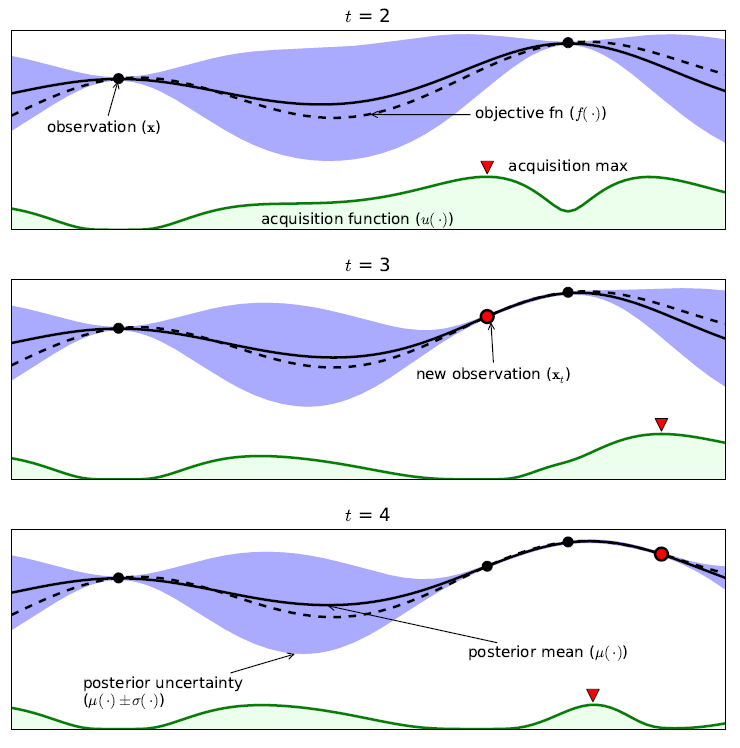

In [2]:
Image('../images/image4.png', width=500, height=501)
# <img alt="" caption="Bayesian Optimization: surrogate function (black, blue) and acquisition function (green)" 
# id="bayesian_optimization" src="../images/image4.png" width="320" height="320">


### Optimal $\alpha$ parameter for Lasso and the house-prices data-set

Example is copied from [here](http://krasserm.github.io/2018/03/21/bayesian-optimization/) and slightly adapted.

In [3]:
!pip install --upgrade scikit-learn

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [5]:
# prepare data
data = pd.read_csv('../data/train.csv', sep=",")
data.drop('Id', axis = 1, inplace = True)
SalePrice = data['SalePrice']
data.drop('SalePrice', axis=1, inplace = True)

categorical = [var for var in data.columns if data[var].dtype=='O']
numerical = [var for var in data.columns if data[var].dtype!='O']
data[categorical] = data[categorical].fillna('None')
data[numerical] += 1

X_train, X_test, y_train, y_test = train_test_split(data, SalePrice, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', PowerTransformer(method='box-cox'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])

X_train_augmented = preprocessor.fit_transform(X_train)
X_test_augmented = preprocessor.transform(X_test)

### objective function

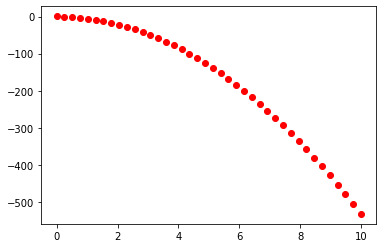

In [6]:
import matplotlib.pyplot as plt
Y = []
X = np.linspace(0, 10, 40).reshape(-1, 1)
for alfa in X:
    model = Lasso(alpha=alfa, fit_intercept=False)
    model.fit(X_train_augmented, np.log1p(y_train))
    Y.append(model.score(X_test_augmented, np.log1p(y_test)))

Y = np.array(Y)
plt.plot(X, Y, 'ro')

In [7]:
def objective_fnc(alfa):
    model = Lasso(alpha=alfa, fit_intercept=False)
    score = model.fit(X_train_augmented, np.log1p(y_train))
    return model.score(X_test_augmented, np.log1p(y_test))


In [8]:
from scipy.stats import norm
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
   
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        imp = imp.reshape((-1, 1))
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

In [9]:
from scipy.optimize import minimize
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x                       
    return min_x.reshape(-1, 1)

In [10]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))


In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_plots import plot_approximation, plot_acquisition

noise = 0.3 
# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = np.array([[5.1], [6.3]])
Y_sample = np.array([objective_fnc(a[0]) for a in X_sample]).reshape((-1,1))
bounds = np.array([[0.0, 10.0]])
   
# Number of iterations
n_iter = 5

In [12]:
%%capture
from matplotlib import pyplot as plt
plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = objective_fnc(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

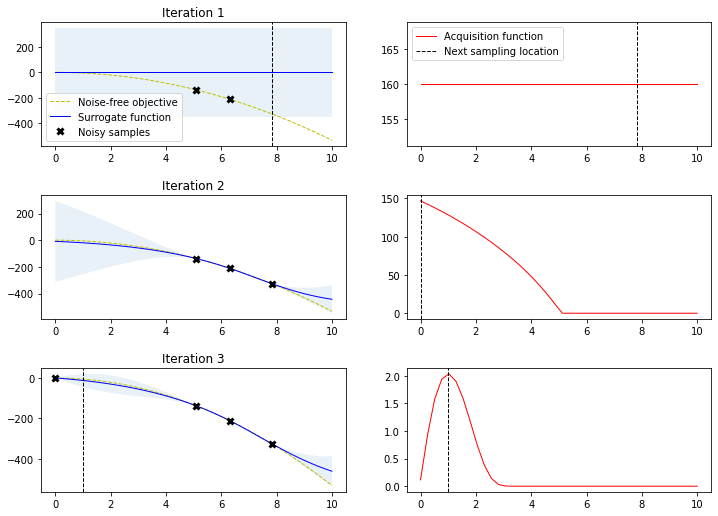

In [13]:
X_sample = np.array([[5.1], [6.3]])
Y_sample = np.array([objective_fnc(a[0]) for a in X_sample]).reshape((-1,1))
bounds = np.array([[0.0, 10.0]])
plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(3):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = objective_fnc(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

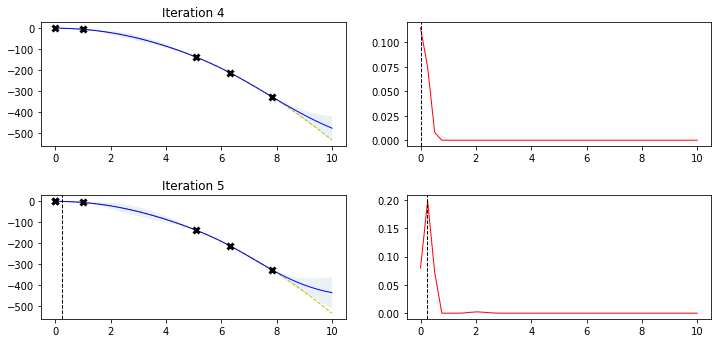

In [14]:
plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(3, 5):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = objective_fnc(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/

# Auto-Sklearn 
https://automl.github.io/auto-sklearn/master/index.html#

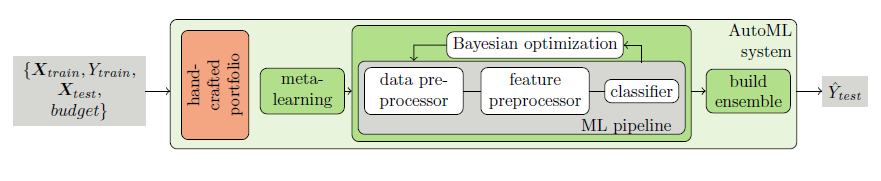

In [15]:
Image("../images/image3.png")
# <img alt="" caption="Auto-Sklearn" 
# id="auto-sklearn" src="../images/image3.png" width="720" height="520">

__SMAC__ (sequential model-based algorithm configuration)

 - Data Set gets divided into n folds
 - For each fold, characteristics of the data are determined and a signature for this fold is calculated with PCA
 - A hyperparameter configuration applied to a fold leads to the following result c (cost) `[h1, h2, h3, h4, h5][s1, s2, s3] -> c`
 - Initially, random combinations of hyperparameters and data folds are evaluated to obtain measurement points
 - For these combinations random forests are calculated
 - New configurations (candidates) are combined with all data-folds signatures and classified by the random forest
 - The predictions of the end-leaves of the random forest are averaged over all data-fold signatures and these results are summed up over all trees in the forest. This results in mean values and variances that are used in the acquisition function (max. objective, min uncertainty).
 - In this way, many different parameter combinations can be tested without having to teach the actual ML algorithm with the new parameter configurations.
 - The hyperparameter combinations with the highest values in the acquisition function are tested against the incumbent (best combination so far) on the ML algorithm. Thus, new measuring points are created and the random forest is relearned.


# autogluon.tabular

### models
  - neural networks (fastai, MXNET)
  - LightGBM
  - Catboost
  - Random-Forests
  - Extremely Randomized Trees
  - $k$-Nearest-Neighbors
  
### methods
  - multi-layer stacking (with predictions of base-models and original data features)
  - ensembles (weighted stacker models)
  - repeated k-fold bagging (bagging of predictions of several k-fold splits)

# Other optimization frameworks

# scikit-optimize
Uses typical __Bayesian Optimization__ as we discussed earlier.

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
train = pd.read_csv('../data/train.csv', sep=",")
test = pd.read_csv('../data/test.csv')

import sklearn
y = train['SalePrice']
X = train.drop('SalePrice', axis=1)
categorical = [var for var in X.columns if X[var].dtype=='O']
numerical = [var for var in X.columns if X[var].dtype!='O']
X[categorical] = X[categorical].fillna('None')
# auto-sklearn can not deal with categorical variables

y = np.log1p(y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=42, test_size=0.2)

In [17]:

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


categorical = [var for var in X_train.columns if train[var].dtype=='O']
numerical = [var for var in X_train.columns if train[var].dtype!='O']

numeric_transformer = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# TPOT (Tree-based Pipeline Optimization Tool)
This package is a wrapper around scikit-learn.<br>

TPOT has
  - supervised classifiers and regressors 
  - preprocessing (preprocessing steps with Scalers, Transformers, PCA, etc. __BUT: no missing-value imputation!__)
  - feature selection methods
  
TPOT tries to find the best pipeline (combination of preprocessing, feature selection and regression/classification). Therefore, it uses __genetic programming__:
  1. a set of random pipelines is constructed and the performance is evaluated in cross-validation
  2. the best performing pipelines (best accuracy with lowest number of operators in the pipeline) are selected
  3. generating offspring: the pipeline steps of the best subset are recombined (cross-over) or just changed in one position
  4. the newly created pipelines are evaluated with cross-validation and the steps 2-4 are repeated
  
### the most important parameters for regression:
  - population_size (number of pipelines in each generation)
  - offspring_size (number of new childs in next generation: usually as population size) 
  - mutation_rate (how many pipelines have to be changed in next generation)
  - crossover_rate (exchange of pipeline-steps among the best pipelines for next generation)
  - scoring='neg_mean_squared_error'
  - subsample (size of the data-set if not the whole data-set)